# Damage Detection

This notebook only shows a possible solution, the final performance of which has much space to improve.

If you have ideas using other methods to get better results, forget this notebook. We expect your solutions.

Or you want to improve the model performances based on methods shown in this notebook, your ideas are samely expected.

And of course you can rewrite or edit whatever you want on this notebook.

References: https://www.kaggle.com/code/lplenka/detectron2-car-damage-detection  
            https://www.kaggle.com/code/lplenka/detectron2-car-damaged-parts-detection

            Coco Car Damage Detection Dataset https://www.kaggle.com/datasets/lplenka/coco-car-damage-detection-dataset

## Package Installation

### Install detectron2 and PyTorch with matching versions
Details of installation https://detectron2.readthedocs.io/en/latest/tutorials/install.html

In [ ]:
!pip install torch==1.8.2 torchvision==0.9.2 torchaudio==0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.8/index.html

### Install Pycocotools

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Import Libraries

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Set constant variables

In [ ]:
dataDir='../input/coco-car-damage-detection-dataset/val' # your dir of images
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "../input/coco-car-damage-detection-dataset/img" # your dir of images

# Initialize the COCO API

In [ ]:
# Initialize coco api for instance annotations
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

# A sample of annotations

In [ ]:
#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset
mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))
mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))

COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part

In [ ]:
# Get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['damage']);
imgIds = coco.getImgIds(catIds=catIds );
random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

In [ ]:
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '8.jpg', 'flickr_url': '', 'height': 1024, 'id': 9, 'license': 1, 'width': 1024}

## Raw Image

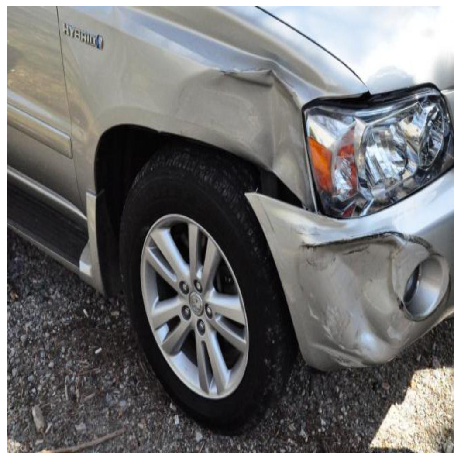

In [ ]:
I = io.imread(img_dir + '/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

## Image with damage annotation

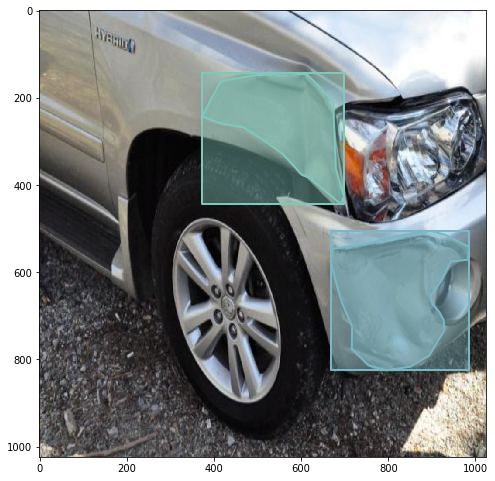

In [ ]:
# Get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)
# Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True )

## Image with parts annotation</center></h3>

In [ ]:
# Get parts annotations
mul_annIds = mul_coco.getAnnIds(imgIds=imgId,iscrowd=None)
mul_anns = mul_coco.loadAnns(mul_annIds)
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(mul_coco.cats.values()):
    category_map.update({ele['id']:ele['name']})

category_map

Out[19]: {1: 'headlamp', 2: 'rear_bumper', 3: 'door', 4: 'hood', 5: 'front_bumper'}

Parts are: ['door', 'front_bumper', 'headlamp', 'hood']

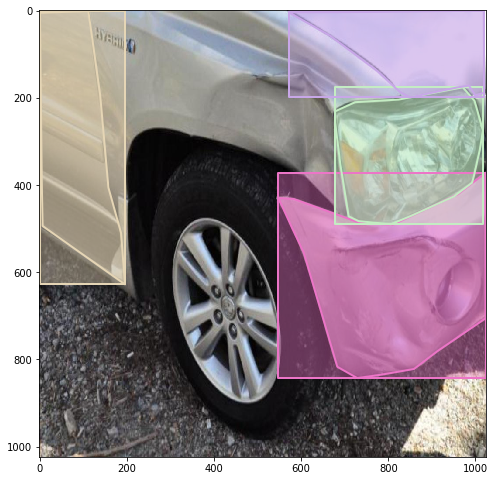

In [ ]:
# Create a list of parts in the image
parts = []
for region in mul_anns:
    parts.append(category_map[region['category_id']])
print("Parts are:", parts) 

# Plot Parts
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('on')
mul_coco.showAnns(mul_anns, draw_bbox=True )

# Train object detection model using Detectron 2

## Import libraries

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [ ]:
# To find out inconsistent CUDA versions, if there is not "failed" word in this output then things are fine.
!python -m detectron2.utils.collect_env

# Train Model 1 - Damage Detection Model

## Register Car Damage Dataset

In [ ]:
dataset_dir = "../" # your dir
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_train", {}, os.path.join(dataset_dir,train_dir,"COCO_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
dataset_dicts = DatasetCatalog.get("car_dataset_train")
metadata_dicts = MetadataCatalog.get("car_dataset_train")

## Training

In [ ]:
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg1 = get_cfg()
cfg1.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # Load pretrained model from model zoo. You can try other models, maybe you can get better results :)
cfg1.DATASETS.TRAIN = ("car_dataset_train",)
cfg1.DATASETS.TEST = ("car_dataset_val",)
cfg1.DATALOADER.NUM_WORKERS = 4
cfg1.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Load weights from model zoo
#cfg.MODEL.WEIGHTS = os.path.join("....../model_final.pth") # Load your previously trained weights

cfg1.SOLVER.IMS_PER_BATCH = 4
cfg1.SOLVER.BASE_LR = 0.001  
cfg1.SOLVER.MAX_ITER = 600 
cfg1.SOLVER.GAMMA = 0.05
cfg1.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg1.MODEL.RETINANET.NUM_CLASSES = 1
cfg1.TEST.EVAL_PERIOD = 100
cfg1['MODEL']['DEVICE']= 'cuda'
cfg1.OUTPUT_DIR= "your output dir"

In [ ]:
!rm -rf cfg1.OUTPUT_DIR

os.makedirs(cfg1.OUTPUT_DIR, exist_ok=True)
trainer1 = CocoTrainer(cfg1) 
trainer1.resume_or_load(resume=False)
trainer1.train()

## Tensorboard

In [ ]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir cfg1.OUTPUT_DIR

## Model Evaluation

In [ ]:
evaluator = COCOEvaluator("car_dataset_val", cfg1, False, output_dir="your dir")
val_loader = build_detection_test_loader(cfg1, "car_dataset_val")
print(inference_on_dataset(trainer1.model, val_loader, evaluator))

## Model Inference

In [ ]:
cfg1.MODEL.WEIGHTS = os.path.join(cfg1.OUTPUT_DIR, "model_final.pth")
cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # You can try some other thresholds
cfg1.DATASETS.TEST = ("car_dataset_val", )
predictor = DefaultPredictor(cfg1)

In [ ]:
tra_dataset_dicts = DatasetCatalog.get("car_dataset_train")
val_dataset_dicts = DatasetCatalog.get("car_dataset_val")
val_metadata_dicts = MetadataCatalog.get("car_dataset_val")

In [ ]:
# Show predicted results on validation dataset
fig, ax = plt.subplots(3,4, figsize =(16,12))
indices=[ax[0][0],ax[0][1],ax[0][2],ax[0][3], ax[1][0],ax[1][1],ax[1][2],ax[1][3], ax[2][0],ax[2][1],ax[2][2],ax[2][3]]
i=-1
for d in random.sample(val_dataset_dicts, 11):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW  
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

# Train Model 2 - Car Parts Segmentation Model

## Register Car Parts Dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_mul_train", {}, os.path.join(dataset_dir,train_dir,"COCO_mul_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_mul_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [ ]:
dataset_dicts = DatasetCatalog.get("car_dataset_mul_train")
metadata_dicts = MetadataCatalog.get("car_dataset_mul_train")

## Training

In [ ]:
cfg2 = get_cfg()
cfg2.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg2.DATASETS.TRAIN = ("car_dataset_mul_train",)
cfg2.DATASETS.TEST = ("car_dataset_mul_val",)
cfg2.DATALOADER.NUM_WORKERS = 4
cfg2.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg2.SOLVER.IMS_PER_BATCH = 4
cfg2.SOLVER.BASE_LR = 0.001  
cfg2.SOLVER.WARMUP_ITERS = 700
cfg2.SOLVER.MAX_ITER = 1801 
cfg2.SOLVER.STEPS = (1600, 1800)
cfg2.SOLVER.GAMMA = 0.05
cfg2.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg2.MODEL.ROI_HEADS.NUM_CLASSES = 5  
cfg2.MODEL.RETINANET.NUM_CLASSES = 5 
cfg2.TEST.EVAL_PERIOD = 100
cfg2.OUTPUT_DIR="your output dir 2"

In [ ]:
!rm -rf cfg2.OUTPUT_DIR

os.makedirs(cfg2.OUTPUT_DIR, exist_ok=True)
trainer2 = CocoTrainer(cfg2) 
trainer2.resume_or_load(resume=False)
trainer2.train()

## Tensorboard

In [ ]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir cfg2.OUTPUT_DIR

## Model Evaluation

In [ ]:
evaluator = COCOEvaluator("car_dataset_mul_val", cfg2, False, output_dir="your dir")
val_loader = build_detection_test_loader(cfg2, "car_dataset_mul_val")
print(inference_on_dataset(trainer2.model, val_loader, evaluator))

## Model Inference

In [ ]:
cfg2.MODEL.WEIGHTS = os.path.join(cfg2.OUTPUT_DIR, "model_final.pth")
cfg2.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # You can try some other thresholds
cfg2.DATASETS.TEST = ("car_dataset_mul_val" )
predictor = DefaultPredictor(cfg2)

In [ ]:
val_dataset_dicts = DatasetCatalog.get("car_dataset_mul_val")
val_metadata_dicts = MetadataCatalog.get("car_dataset_mul_val")

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(val_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW  
    )
    print(outputs)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

# Combine outputs of two models for information of the damaged part

In [ ]:
dataset_dir = "../" #"Your dir"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

## Load trained model

### Model 1 Damage detection

In [ ]:
# Model 1
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.RETINANET.NUM_CLASSES = 1 
cfg.MODEL.WEIGHTS = os.path.join("......../model1/model_final.pth") #Load your model 1 weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # You can try some other thresholds
cfg['MODEL']['DEVICE']='cuda'
#cfg['MODEL']['DEVICE']='cpu'
damage_predictor = DefaultPredictor(cfg)

### Model 2 Car parts segmentation

In [ ]:
# Model 2
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 5 
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 5 
cfg_mul.MODEL.WEIGHTS = os.path.join("......../model2/model_final.pth") #Load your model 2 weights
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # You can try some other thresholds
cfg_mul['MODEL']['DEVICE']='cuda'
#cfg_mul['MODEL']['DEVICE']='cpu'
part_predictor = DefaultPredictor(cfg_mul)

### Model inference

In [ ]:
damage_class_map= {0:'damage'}
parts_class_map={0:'headlamp',1:'rear_bumper', 2:'door', 3:'hood', 4: 'front_bumper'}

In [ ]:
# How to improve this part? Please design a better algorithm.

def detect_damage_part(damage_dict, parts_dict):
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    #if len(damage_dict)==0 or len(parts_dict)==0 :
    #  return None
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]
    return list(set(part_name.values()))
  except Exception as e:
    print(e)
    
def CombinePredictOutputs(damage_outputs,parts_outputs):
  damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
  damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
  damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))
  if len(damage_dict)==0:
    return None
  parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
  parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()
  parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers))
  if len(parts_dict)==0:
    return None
  damagePart = detect_damage_part(damage_dict,parts_dict)
  return damagePart

def PredictDamagePart(damage_predictor, part_predictor, img):
  # Input: two predictors from two models "part_predictor" and "damage_predictor"
  #        img: image location
  im = io.imread(img)
  damage_outputs = damage_predictor(im)
  parts_outputs  = part_predictor(im)
  if len(damage_outputs["instances"])==0 or len(parts_outputs["instances"])==0 :
    return ["unknown"]
  damagePart =  CombinePredictOutputs(damage_outputs,parts_outputs)
  if damagePart is None:
    return ["unknown"]
  return damagePart

### Visualize results of two models

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("/content/drive/MyDrive/damageDataset/val/42.jpg")

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW  
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

### Next, apply your models to the new dataset and check the accuracy. (Don't forget to match the labels from different datasets)

### The new dataset has 753 images in the folder "image". Whose labels are in the csv file "new_index.csv".

### How can you improve the performance of models on the new dataset?

### At the end, please apply your prediction result on csv file "Test_damage_labeled.csv" and the notebook/code and provide us with the model accuracy.